In [1]:
import sys
sys.path.append("../../sparsedense/")
from sparsedense import * # our library

In [2]:
import scipy.io as sio
from scipy.sparse import csc_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import networkx as nx
import re
import pickle
from collections import Counter
from itertools import combinations

In [3]:
np.random.seed(23423)

## Reading the file

In [4]:
nipsdb = sio.loadmat('nips_1-17.mat')

In [5]:
for key in nipsdb.keys():
    type_ = str(type(nipsdb[key]))
    shape_ = str(nipsdb[key].shape) if not "__" in key else "---"
    print("key: {:15s} type: {:40s} shape: {:20s}".format(key, type_, shape_))

key: __header__      type: <class 'bytes'>                          shape: ---                 
key: __version__     type: <class 'str'>                            shape: ---                 
key: __globals__     type: <class 'list'>                           shape: ---                 
key: counts          type: <class 'scipy.sparse.csc.csc_matrix'>    shape: (14036, 2484)       
key: words           type: <class 'numpy.ndarray'>                  shape: (1, 14036)          
key: docs_names      type: <class 'numpy.ndarray'>                  shape: (1, 2484)           
key: authors_names   type: <class 'numpy.ndarray'>                  shape: (1, 2865)           
key: docs_authors    type: <class 'scipy.sparse.csc.csc_matrix'>    shape: (2484, 2865)        
key: aw_counts       type: <class 'scipy.sparse.csc.csc_matrix'>    shape: (14036, 2865)       


Print author list and check for possible duplicates

In [6]:
# o = sorted(x[0] for x in nipsdb['authors_names'][0])
# for i, l in enumerate(o):
#     if l[:4] == o[i + 1][:4]:
#         print(i, l)
#         print(i + 1, o[i + 1])

## Collaboration Graph

For this section we'll use

* **The last 5 years of the data only**
* **The largest connected component only**

The resulting is a graph of ~ 500 authors and ~ 1000 edges

Let's create a key of authors and documents

In [7]:
?re.sub

Signature: re.sub(pattern, repl, string, count=0, flags=0)
Docstring:
Return the string obtained by replacing the leftmost
non-overlapping occurrences of the pattern in string by the
replacement repl.  repl can be either a string or a callable;
if a string, backslash escapes in it are processed.  If it is
a callable, it's passed the match object and must return
a replacement string to be used.
File:      c:\users\mbg877\appdata\local\continuum\anaconda3\lib\re.py
Type:      function


In [8]:
def cleanname(x):
    s = x
    s = re.sub("el-", "", s)
    s = re.sub(r"\\c", "c", s)
    s = re.sub(r"\.", "", s)
    s = re.search('([A-Z][a-zA-Z]+)[-]?[A-Za-z]*_([A-Z])', s)
    if s is None:
        print(x)
    ans = '{}_{}'.format(s.group(1), s.group(2))
    return ans

In [9]:
authors = [cleanname(x[0]) for x in nipsdb['authors_names'].flatten()] # extract weird matlab read
# authors[:5]

In [10]:
docs = [x[0] for x in nipsdb['docs_names'].flatten()] # extract weird matlab read
docs[:5]

['1987/0001', '1987/0009', '1987/0022', '1987/0031', '1987/0041']

Now a collaboration graph.

In [11]:
docs_authors = nipsdb['docs_authors']
docauthor_buffer = [[] for _ in range(len(docs))]
for i, j in zip(*docs_authors.nonzero()):
    docauthor_buffer[i].append(j)

In [12]:
docsyear = [int(x[:4]) for x in docs]
maxyear = max(docsyear)

In [13]:
print("Considering years", maxyear - 4, "-", maxyear)

Considering years 1999 - 2003


In [14]:
g = nx.Graph()
for i, alist in enumerate(docauthor_buffer):
    L = len(alist)
    year = docsyear[i]
    if year >= maxyear - 4:
        for l in range(L - 1):
            for k in range(l + 1, L):
                a, b = authors[alist[l]], authors[alist[k]]
                if g.has_edge(a, b):
                    g.edges[a, b]['count'] += 1
                else:
                    g.add_edge(a, b, count=1)

In [15]:
g.number_of_nodes() # removes solo workers

1220

Let's keep only the largest connected component

In [16]:
nx.number_connected_components(g)

182

In [17]:
comps = sorted(nx.connected_components(g), key=len, reverse=True)

In [18]:
gg = nx.induced_subgraph(g, comps[0]).copy()

In [19]:
gg.number_of_nodes()

553

In [20]:
# sorted(gg.nodes())[:300]

In [21]:
gg.number_of_edges()

1166

In [22]:
for ai, aj in list(gg.edges())[-25:]:
    print(ai, "and", aj, "collaborated", gg.edges[ai,aj]["count"], "time(s)")

Vogelstein_R and Cauwenberghs_G collaborated 1 time(s)
Vogelstein_R and Goldberg_D collaborated 1 time(s)
Vogelstein_R and Tenore_F collaborated 1 time(s)
Langford_J and Thrun_S collaborated 1 time(s)
Whittaker_W and Thrun_S collaborated 1 time(s)
Whittaker_W and Whittaker_C collaborated 1 time(s)
Yu_S and Lee_T collaborated 1 time(s)
Winn_J and Spiegelhalter_D collaborated 1 time(s)
Cauwenberghs_G and Goldberg_D collaborated 1 time(s)
Cauwenberghs_G and Tenore_F collaborated 1 time(s)
Schoner_H and Obermayer_K collaborated 1 time(s)
Goldberg_D and Tenore_F collaborated 1 time(s)
Hinton_G and Mayraz_G collaborated 1 time(s)
Hinton_G and Zemel_R collaborated 1 time(s)
Delbruck_T and Indiveri_G collaborated 1 time(s)
Wu_S and Nakahara_H collaborated 1 time(s)
Strother_S and Kjems_U collaborated 1 time(s)
Gu_F and Cichocki_A collaborated 1 time(s)
Schwabe_L and Obermayer_K collaborated 1 time(s)
Thrun_S and Whittaker_C collaborated 1 time(s)
Zhu_J and Rosset_S collaborated 2 time(s)
Herbr

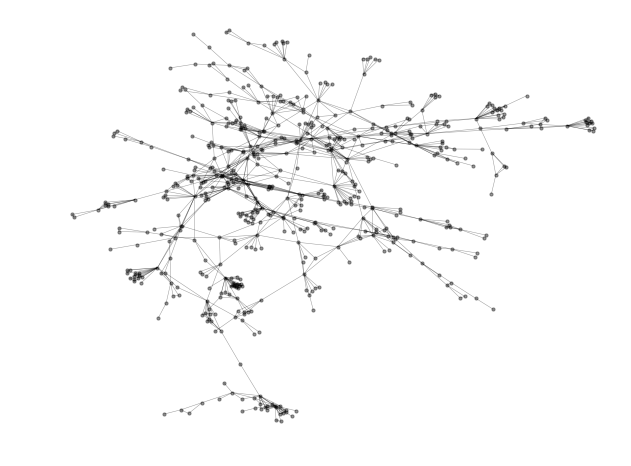

In [23]:
fig = plt.figure(figsize=(8, 6))
pos=nx.spring_layout(gg)
nx.draw(gg, 
    pos=pos,
    node_color="black", 
    edge_color="black",
    width=0.5,
    node_size=10,
    alpha=0.4)
plt.savefig("nips99-03.png", format="PNG",  bbox_inches='tight')
plt.show()

In [24]:
from networkx.algorithms import community

In [25]:
communities_generator = community.girvan_newman(gg)
nodeslist = sorted([x for x in next(communities_generator)], key=len, reverse=True)
nodes = []
for x in nodeslist:
    nodes.extend(x)

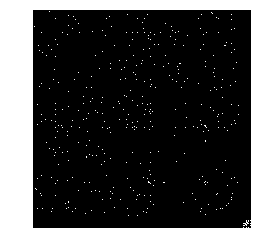

In [26]:
adj = nx.adjacency_matrix(gg, nodelist=nodes)

plt.imshow(1 - adj.todense(), cmap='binary')
plt.axis('off')
plt.savefig("nips99-03-adjmat.png",  bbox_inches='tight')

In [27]:
adj = nx.adjacency_matrix(gg).toarray()
links = []
N = adj.shape[0]
for i in range(N - 1):
    for j in range(i + 1, N):
        if adj[i, j] == 1:
            links.append([i, j])
np.savetxt('nips99-03_links.tsv', np.array(links), delimiter='\t', fmt='%d')
author_names = [[i, x] for i, x in enumerate(gg.nodes())]
with open('nips99-03_names.tsv', 'w') as f:
    for i, a in author_names:
        f.write("{:d}\t{:s}\n".format(i, a))

## Graph properties

Text(0.5,1,'Adjacency Matrix of NIPS collaborations')

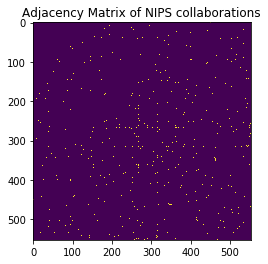

In [28]:
plt.imshow(adj) # we see a very sparse matrix
plt.title("Adjacency Matrix of NIPS collaborations")

In [29]:
nx.graph_number_of_cliques(gg)

333

In [30]:
max_clique_size_per_author = nx.node_clique_number(gg, list(gg.nodes()))
max_clique_size_per_author = list(max_clique_size_per_author.values())
sum(max_clique_size_per_author) / len(max_clique_size_per_author) # mean

3.9439421338155514

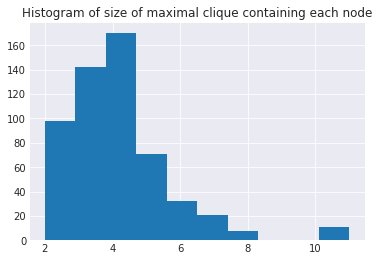

In [31]:
with sns.axes_style("darkgrid"):
    plt.hist(max_clique_size_per_author)
    plt.title("Histogram of size of maximal clique containing each node")

In [32]:
degree_author = nx.degree(gg, list(gg.nodes()))
degree_author = [x[1] for x in list(degree_author)]
sum(degree_author) / len(degree_author) # mean

4.216998191681736

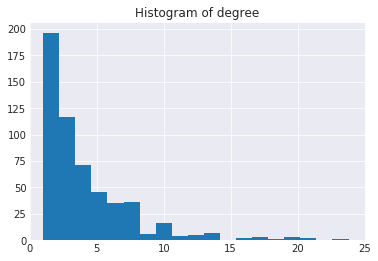

In [33]:
with sns.axes_style("darkgrid"):
    plt.hist(degree_author, bins=25)
    plt.title("Histogram of degree")
    plt.xlim(0, 25)

## Run partial model

In [34]:
net = adj.copy() # important to pass from matrix to array type
for i in range(net.shape[0]):
    net[i, i] = 1

In [35]:
# alphavals = [10.]
# sigmavals = [0.25]
# pievals = [0.5]
# lambvals = [10.]
# #sigmavals = [0.25, 0.75]
# #pievals = [0.9, 0.5]
# #lambvals = [10., 1.]

# params = []
# for a in alphavals:
#     for s in sigmavals:
#         for p in pievals:
#             for l in lambvals:
#                 params.append({'alpha': a, 'sigma': s, 'lamb': l, 'pie': p})
# params

In [36]:
# filename = [re.sub('\.', '-', 'nipspartial_a{}_s{}_l{}_p{}'
#                     .format(x['alpha'], x['sigma'], x['lamb'], x['pie'])) for x in params]
# filename

In [37]:
# with open('nips_partial_a10_s0-5_l10_p0-95.pkl', 'rb') as input_file:
#     pmodel = pickle.load(input_file)

In [38]:
#pmodel = NetworkPartial(net, links, 10., 0.5, 10, 0.95)
#pmodel.set_hyperpriors(alpha_params = [10., 1.], sigma_params = [1., 1.])
#Ktrace = []
#b = 0

In [39]:
# with open('nips_partial.pkl', 'rb') as f:
#     mod = pickle.load(f)

In [40]:
args = {'alpha': 5.0, 'sigma': 0.25, 'lamb': 100.0, 'pie': 0.9}
hypers = {'alpha_params': [1., 1.], 'sigma_params': [1., 1.]}

In [41]:
niter = 1000
batch = 10

Ks = np.zeros(niter, dtype=int)
alphas = np.zeros(niter)
sigmas = np.zeros(niter)
lambs = np.zeros(niter)
pies = np.zeros(niter)
lps = np.zeros(niter)


mod = NetworkPartial(net, links, **args)
mod.set_hyperpriors(**hypers)
mod.clique_init()

In [43]:
with open('nips_partial_run_newnames.pkl', 'rb') as fn:
    mod = pickle.load(fn)

In [346]:
print("=== Start === K: {:4d}, alpha: {:4.2f}, sigma: {:.2}, lamb: {:5.2f}, pie: {:.2}, logl: {}". \
    format(mod.K, mod.alpha, mod.sigma, mod.lamb, mod.pie, mod.log_lik()))

it = 201
for i in range(it + 1, niter):
    sample_hypers = False if it < 200 else True
    
    mod.sample(
        sample_hypers = sample_hypers,
        num_iters = batch, 
        dot_every = batch + 1,
        verbose = False,
        do_gibbs = True)
    
    # assign to trace
    Ks[i], alphas[i], sigmas[i], lambs[i], pies[i], lps[i] = mod.K, mod.alpha, mod.sigma, mod.lamb, mod.pie, mod.log_lik()
    
    # print
    print("Iter: {:4d}, K: {:4d}, alpha: {:4.2f}, sigma: {:.2}, lamb: {:4.2f}, pie: {:.2}, logl: {}". \
          format(it * batch, Ks[i], alphas[i], sigmas[i], lambs[i], pies[i], lps[i], it))
    
    it += 1
    
    if lps[i] > -50.0:
        break
     
    pickle.dump(mod, open('nips_partial_run_newnames.pkl', 'wb'))
#     pickle.dump([Ks, alphas, sigmas, lambs, pies, lps], open('nips_partial_traces.pkl', 'wb'))

=== Start === K:  151, alpha: 5.01, sigma: 0.28, lamb: 91.54, pie: 0.88, logl: -2193.243097175202
Iter: 2010, K:  149, alpha: 5.01, sigma: 0.34, lamb: 71.29, pie: 0.82, logl: -2046.2007559351423
Iter: 2020, K:  148, alpha: 5.04, sigma: 0.35, lamb: 78.37, pie: 0.78, logl: -2011.5219196481737
Iter: 2030, K:  147, alpha: 5.07, sigma: 0.39, lamb: 82.96, pie: 0.75, logl: -1916.7553997400476
Iter: 2040, K:  144, alpha: 5.09, sigma: 0.42, lamb: 81.29, pie: 0.71, logl: -1804.5794712804397
Iter: 2050, K:  140, alpha: 5.13, sigma: 0.42, lamb: 66.12, pie: 0.68, logl: -1741.1334999517953
Iter: 2060, K:  139, alpha: 5.15, sigma: 0.44, lamb: 63.91, pie: 0.66, logl: -1725.1463893403675
Iter: 2070, K:  137, alpha: 5.18, sigma: 0.49, lamb: 69.98, pie: 0.65, logl: -1572.7824788476496
Iter: 2080, K:  131, alpha: 5.23, sigma: 0.54, lamb: 75.60, pie: 0.65, logl: -1419.1589310563086
Iter: 2090, K:  126, alpha: 5.22, sigma: 0.57, lamb: 73.04, pie: 0.62, logl: -1315.1173124115785
Iter: 2100, K:  124, alpha: 5

In [347]:
# batch_size = 50
# nreps = 100

# for l, args in enumerate(params):
#     if l > 0:
#         print('Training with params:', args, '---------------------------------')
#         trace = np.zeros((nreps, 6))
#         # pmodel = NetworkPartial(net, links, **args)
#         # pmodel.set_hyperpriors(**hyperpars)
#         with open(filename[l] + '.pkl', 'rb') as input_file:
#             pmodel = pickle.load(input_file)
#         for i in range(nreps):
#             pmodel.sample(
#                 sample_hypers = True,
#                 num_iters = batch_size, 
#                 dot_every = batch_size + 1,
#                 do_gibbs = True)
#             trace[i,:] = (i + 1) * batch_size, pmodel.K, pmodel.alpha, pmodel.sigma, pmodel.lamb, pmodel.pie
#             print(" ", trace[i, :])
#             with open(filename[l] + '.pkl', 'wb') as output_file:
#                 pickle.dump(pmodel, output_file, pickle.HIGHEST_PROTOCOL)
#             with open(filename[l] + '_trace.pkl', 'wb') as output_file:
#                 pickle.dump(trace, output_file, pickle.HIGHEST_PROTOCOL)

In [44]:
Ks = mod.

# Ks2 = Ks[:314]
# alphas2 = alphas[:314]
# sigmas2 = sigmas[:314]
# lambs2 = lambs[:314]
# pies2 = pies[:314]
# lps2 = lps[:314]

Ks2 = Ks[-314:]
alphas2 = alphas[-314:]
sigmas2 = sigmas[-314:]
lambs2 = lambs[-314:]
pies2 = pies[-314:]
lps2 = lps[-314:]


pmodel = mod

In [45]:
maxll_idx = lps2.argmax()
lps2.max()

0.0

In [47]:
ath = list(gg.nodes())

In [49]:
len(ath)

553

In [351]:
cliques = []
plinks = []
for i in range(pmodel.Z.shape[0]):
    cl = []
    for j in range(pmodel.Z.shape[1]):
        if pmodel.Z[i, j] == 1:
            cl.append(ath[j])
    cliques.append(cl)
    L = len(cl)
    for l in range(L - 1):
        for k in range(l + 1, L):
            plinks.append([cl[l], cl[k]])
# cliques = [[ath[x] for x in list(np.where(pmodel.Z[i,:] == 1)[0])] for i in pmodel.Z.shape[0]]

In [352]:
ref_authors = ['Ghahramani_Z', 'Amari_S', 'Blei_D', 'Jordan_M', 'MacKay_D', 'Vapnik_V']
for ref in ref_authors:
    print(ref)
    for cl in cliques:
        if ref in cl:
            print(" ", cl)

Ghahramani_Z
  ['Mnih_A', 'Osindero_S', 'Sallans_B', 'Roweis_S', 'Hinton_G', 'Paccanaro_A', 'Saul_L', 'Brown_A', 'Zemel_R', 'Welling_M', 'Teh_Y', 'Ghahramani_Z', 'Mayraz_G']
  ['Verbeek_J', 'Roweis_S', 'Snelson_E', 'Vlassis_N', 'Jin_R', 'Ghahramani_Z', 'Rasmussen_C', 'Neal_R', 'Beal_M']
Amari_S
  ['Saito_K', 'Amari_S', 'Ozeki_T', 'Ueda_N', 'Minami_Y', 'Nakamura_A', 'Watanabe_S', 'Park_H']
  ['Fukumizu_K', 'Amari_S', 'Bartlett_P', 'Jordan_M', 'Wu_S', 'McAuliffe_J', 'Nakahara_H', 'Murata_N', 'Akaho_S', 'Bach_F']
  ['Cao_J', 'Amari_S', 'Ikeda_S', 'Gu_F', 'Tanaka_T', 'Zhang_L', 'Li_Y', 'Shishkin_S', 'Cichocki_A', 'Long_P']
Blei_D
  ['Blei_D', 'Stromsten_S', 'DeSilva_V', 'Jordan_M', 'Kemp_C', 'Ng_A', 'Steyvers_M', 'Griffiths_T', 'Danks_D', 'Tenenbaum_J', 'Sanjana_N']
Jordan_M
  ['Weare_C', 'Jordan_M', 'Platt_J', 'Burges_C', 'Liblit_B', 'Aiken_A', 'Zheng_A', 'Swenson_S', 'Crisp_D']
  ['Sundararajan_S', 'Jordan_M', 'Ghaoui_L', 'Bhattacharyya_C', 'Lanckriet_G', 'Keerthi_S', 'Nilim_A']
  ['Kim_

Same thing but print only the *NEW* edges

In [353]:
for ref in ref_authors:
    print(ref)
    for cl in cliques:
        if ref in cl:
            s = ""
            for a in cl:
                if not gg.has_edge(ref, a) and not ref == a:
                    s += a + ", "
            print(" ", s)

Ghahramani_Z
  Mnih_A, Osindero_S, Sallans_B, Roweis_S, Paccanaro_A, Saul_L, Brown_A, Zemel_R, Welling_M, Mayraz_G, 
  Verbeek_J, Roweis_S, Vlassis_N, Neal_R, 
Amari_S
  Saito_K, Ueda_N, Minami_Y, Nakamura_A, 
  Bartlett_P, Jordan_M, McAuliffe_J, Bach_F, 
  Long_P, 
Blei_D
  Stromsten_S, DeSilva_V, Kemp_C, Steyvers_M, Danks_D, Sanjana_N, 
Jordan_M
  Weare_C, Platt_J, Burges_C, Swenson_S, Crisp_D, 
  Sundararajan_S, Keerthi_S, Nilim_A, 
  Yedidia_J, Freeman_W, Yanover_C, 
  Amari_S, Wu_S, Nakahara_H, Murata_N, Akaho_S, 
  Stromsten_S, DeSilva_V, Kemp_C, Steyvers_M, Danks_D, Sanjana_N, 
  Chichilnisky_E, Simoncelli_E, Pillow_J, Schwartz_O, Wang_Z, Paninski_L, 
MacKay_D
  Rokni_U, Isbell_C, Allen_J, Shriki_O, Saul_L, Sha_F, Sompolinski_H, Shamir_M, LeCun_Y, 
Vapnik_V
  Roitershtein_A, Jaakkola_T, Steck_H, Szummer_M, 
  Sadr_J, Vetter_T, Heisele_B, Serre_T, Sinha_P, Thoresz_K, 
  Bakir_G, Bousquet_O, Gretton_A, Lal_T, Audibert_J, Zhou_D, Hein_M, Herrmann_D, 


Show resulting graph with new edges in red

In [359]:
# nethat = (pmodel.Z.transpose() @ pmodel.Z).astype(int)
# for i in range(nethat.shape[0]):
#     nethat[i, i] == 0
# gghat = nx.from_numpy_matrix(nethat)
gghat = nx.Graph()
gghat.add_edges_from(plinks)

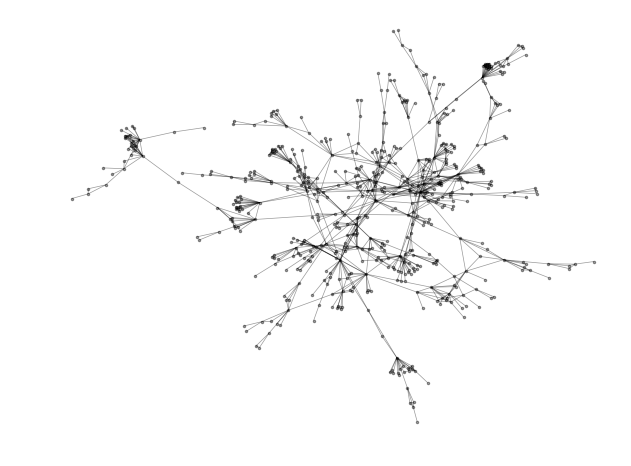

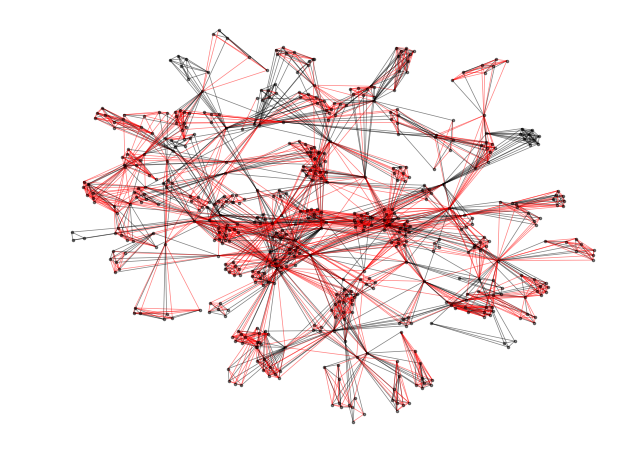

In [431]:
fig = plt.figure(figsize=(8, 6))
pos=nx.spring_layout(gg)
nx.draw(gg, 
    pos=pos,
    node_color="black", 
    edge_color="black",
    width=0.7,
    node_size=6,
    alpha=0.4)
plt.savefig("partial_nips99-03_original.png", format="PNG",  bbox_inches='tight')
plt.show()

pos0=nx.spring_layout(gghat, k=0.2)
fig = plt.figure(figsize=(8, 6))
edgec = ["black" if gg.has_edge(*x) else "red" for x in gghat.edges()]
nx.draw(gghat, 
    pos=pos0,
    node_color="black", 
    edge_color=edgec,
    width=0.7,
    node_size=6,
    alpha=0.5)
plt.savefig("partial_nips99-03_partial.png", format="PNG",  bbox_inches='tight')
plt.show()

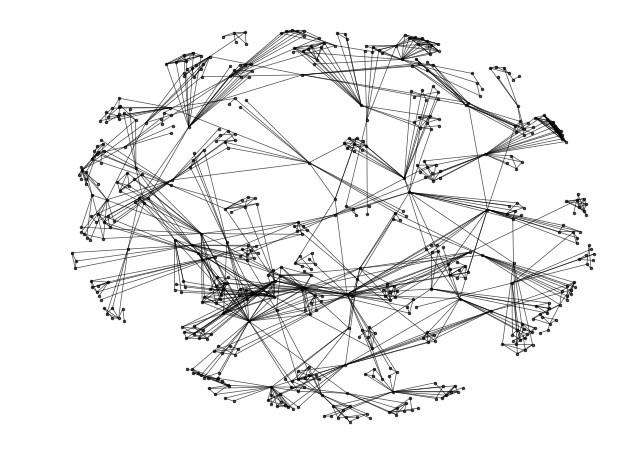

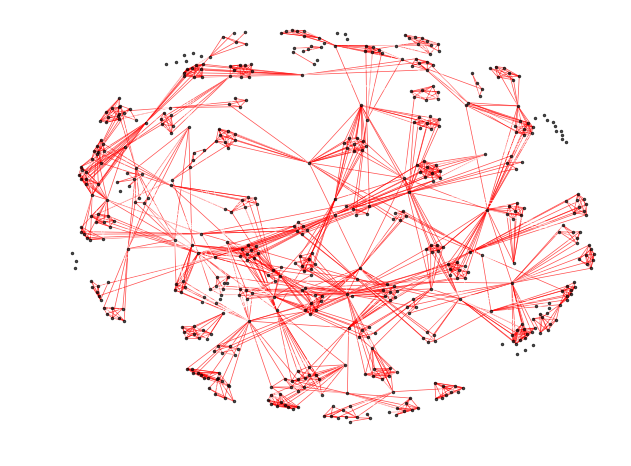

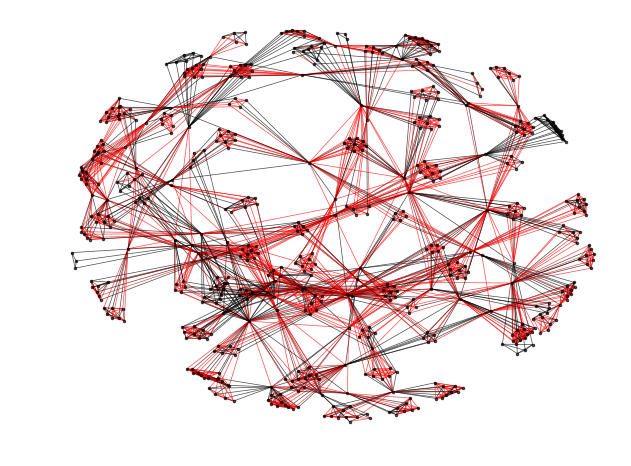

In [442]:
fig = plt.figure(figsize=(8, 6))

#pos=nx.kamada_kawai_layout(gghat, pos=pos0)
pos=nx.spring_layout(gghat, pos=pos0, k=0.3)

nx.draw(gg, 
    pos=pos,
    node_color="black", 
    edge_color="black",
    width=0.7,
    node_size=6,
    alpha=0.7)
plt.savefig("partial_nips99-03_original_samepos.png", format="PNG",  bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8, 6))
edgec = ["white" if gg.has_edge(*x) else "red" for x in gghat.edges()]
nx.draw(gghat, 
    pos=pos,
    node_color="black", 
    edge_color=edgec,
    width=0.7,
    node_size=6,
    alpha=0.7)
plt.savefig("partial_nips99-03_new_samepos.png", format="PNG",  bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8, 6))
edgec = ["black" if gg.has_edge(*x) else "red" for x in gghat.edges()]
nx.draw(gghat, 
    pos=pos,
    node_color="black", 
    edge_color=edgec,
    width=0.7,
    node_size=6,
    alpha=0.7)
plt.savefig("partial_nips99-03_full_samepos.png", format="PNG",  bbox_inches='tight')
plt.show()

## Clique statistics

Number of authors that are in n cliques:

In [63]:
for i in range(8):
    N = (mod.Z.sum(axis=0)==i+1).sum()
    print("Authors in {} cliques: {}".format(i + 1, N))

Authors in 1 cliques: 491
Authors in 2 cliques: 36
Authors in 3 cliques: 12
Authors in 4 cliques: 10
Authors in 5 cliques: 2
Authors in 6 cliques: 2
Authors in 7 cliques: 0
Authors in 8 cliques: 0


Fraction of new edges in new graph

In [443]:
N = gghat.number_of_edges()
n = sum([1 for x in gghat.edges() if gg.has_edge(*x)])
print("Fraction of edges that are present in original graph:", n / N)

Fraction of edges that are present in original graph: 0.41245136186770426


In [444]:
cliqueadj = pmodel.Z @ pmodel.Z.transpose()

In [446]:
# csize.mean()

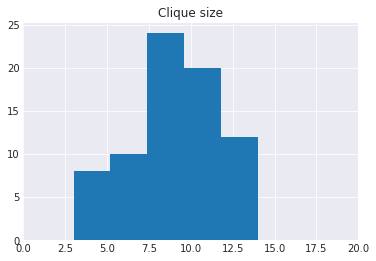

In [447]:
# clique size
csize = cliqueadj.diagonal()
with sns.axes_style("darkgrid"):
    plt.hist(csize, bins=5)
    plt.title("Clique size")
    plt.xlim(0, 20)

In [472]:
csize.mean()

8.932432432432432

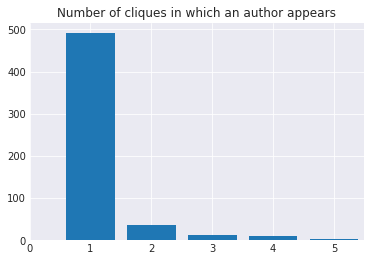

In [448]:
# clique memebership number
membercountdict = Counter(pmodel.Z.sum(axis=0).astype(int))
membershipnum = [membercountdict[i] for i in sorted(membercountdict.keys())]
with sns.axes_style("darkgrid"):
    pos = sorted(membercountdict.keys())
    plt.bar(pos, membershipnum)
    plt.title("Number of cliques in which an author appears")
    plt.xlim(0, 5.5)

In [449]:
tot = sum(membercountdict.values())
for i, x in membercountdict.items():
    print(i, x, x / tot)
print(tot)

1 491 0.8878842676311031
3 12 0.0216998191681736
2 36 0.0650994575045208
4 10 0.018083182640144666
5 2 0.003616636528028933
6 2 0.003616636528028933
553


Now some distances

In [450]:
dists = dict(nx.all_pairs_shortest_path_length(gg))

In [451]:
mean_dist = np.zeros(len(cliques))
for l, cl in enumerate(cliques):
    L = len(cl)
    for i in range(L - 1):
        for j in range(i + 1, L):
            mean_dist[l] += dists[cl[i]][cl[j]]
    mean_dist[l] /= 0.5 * L * (L - 1)
    if mean_dist[l] >= 4:
        print(cl)

['Muller_K', 'Dayan_P', 'Blankertz_B', 'Dornhege_G', 'Kali_S', 'Curio_G']
['Koller_D', 'Winther_O', 'Lotner_N', 'Friedman_N', 'Hojen_P', 'Strother_S', 'Hansen_L', 'Elidan_G', 'Rasmussen_C', 'Kjems_U']


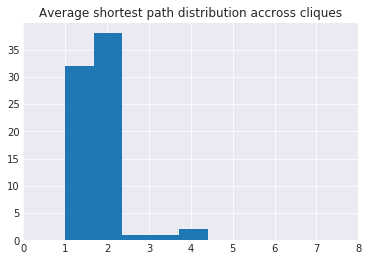

In [452]:
# clique size
with sns.axes_style("darkgrid"):
    plt.hist(mean_dist, bins=5)
    plt.title("Average shortest path distribution accross cliques")
    plt.xlim(0, 8)

## Making sense of cliques

In [453]:
with open('top1000words.txt') as f:
    top1000 = set(f.read().splitlines()) # should be way faster to search in a set
with open('top10000words.txt') as f:
    top10000 = set(f.read().splitlines())
with open('top100000words.txt', encoding="utf-8") as f:
    top100000 = set(f.read().splitlines())

## TF-IFD

### Key assumption Model 1

1. The term frequency count of an author is the taken from all the documents where he has participated
2. (deprecated) A clique is the weighted average of the term frequencies. This will mitigate the effect of one author having more lengthy publications.
3. (deprecated) only consider words that are common accross all authors of a clique.

#### Step 1: term frequency of authors

In [454]:
words = [x[0] for x in nipsdb['words'].flatten()]
aw_counts = nipsdb['aw_counts'].tocoo()

In [455]:
authors_lc = set(x.lower()[:-2] for x in authors)
print(list(authors_lc)[:10])

['pillow', 'monti', 'grebert', 'doyle', 'jabri', 'kemp', 'yang', 'ihler', 'peng', 'ortiz']


In [456]:
author_tf = {x: {} for x in authors}
# Adding words to author from data
for i, j, v in zip(aw_counts.row, aw_counts.col, aw_counts.data):
    author = authors[j]
    word = words[i]
    if word[-1] == 's':
        word = word[:-1]
    if (not word in top1000) and (not word in authors_lc): 
        author_tf[author][word] = v
    
# Normalise
# for author in author_tf.keys():
#     N = sum(author_tf[author].values())
#     for w, v in author_tf[author].items():
#         author_tf[author][w] /= N

In [457]:
ex = author_tf['Jordan_M']
sorted(ex.items(), key=lambda x: (x[1], x[0]), reverse=True)[:10]

[('learning', 0.1423164809825422),
 ('neural', 0.09270645415028567),
 ('data', 0.08943057737802614),
 ('network', 0.0767557446514068),
 ('universality', 0.06294706422761132),
 ('model', 0.060607716819861844),
 ('parameter', 0.057163754525780285),
 ('probability', 0.05335098051562119),
 ('hidden', 0.049869618958568854),
 ('naftali', 0.04668276618437712)]

In [458]:
sum(ex.values())

10.493247772212456

Average per clique

In [459]:
[len(author_tf[x].keys()) for x in cliques[0]]

[632, 325, 2663, 2153, 584, 832, 1221, 2307]

In [460]:
common_only = False
clique_tf = [{} for _ in range(len(cliques))]
vocab = set()
for i, cl in enumerate(cliques):
    L = len(cl)
    cl_tf = clique_tf[i]
    # determine common vocab
    common_vocab = set(author_tf[cl[0]].keys())
    for j in range(1, len(cl)):
        common_vocab.intersection_update(set(author_tf[cl[j]].keys()))
    for author in cl:
        for w, v in author_tf[author].items():
            if common_only and not w in common_vocab:
                pass
            else:
                if not w in cl_tf:
                    cl_tf[w] = 0.
                cl_tf[w] += v / L
                vocab.add(w)

In [461]:
ex = clique_tf[0]
sorted(ex.items(), key=lambda x: (x[1], x[0]), reverse=True)[:20]

[('neural', 0.028231776935068488),
 ('institute', 0.014875855166543717),
 ('distinguished', 0.009879288303789934),
 ('learning', 0.009865565109392294),
 ('naftali', 0.009660674197159984),
 ('quantitative', 0.009139727485267),
 ('training', 0.008643586746044584),
 ('universality', 0.008081571823623132),
 ('theory', 0.007590771892049635),
 ('independence', 0.007579948259400295),
 ('rob', 0.007268937727714193),
 ('network', 0.007246867456757969),
 ('neuron', 0.007093652854897874),
 ('approach', 0.006842362648785961),
 ('jersey', 0.006803963080233897),
 ('data', 0.006759436547877721),
 ('shown', 0.006692547689651535),
 ('linear', 0.006468271849933752),
 ('parameter', 0.0063247807051747115),
 ('probability', 0.006259314880458218)]

In [462]:
sum(ex.values())

1.669484130974661

#### Step 2: IDF

Count the number of appearances of word in documents.

In [463]:
def idf(doc_words, vocab):
    M = len(doc_words)
    term_cnt = {w: 0 for w in vocab}
    for w in vocab: 
        for doc in doc_words:
            if w in doc:
                term_cnt[w] += 1
    idf = {w: M / term_cnt[w] for w in vocab}
    return idf

In [464]:
doc_words = [list(cl.keys()) for cl in clique_tf]
clique_idf = idf(doc_words, vocab)

In [465]:
sorted(clique_idf.items(), key=lambda x: (x[1], x[0]), reverse=True)[:10]

[('zed', 74.0),
 ('yer', 74.0),
 ('xjy', 74.0),
 ('xiv', 74.0),
 ('wooter', 74.0),
 ('wixi', 74.0),
 ('wien', 74.0),
 ('whitley', 74.0),
 ('whe', 74.0),
 ('wet', 74.0)]

In [466]:
who = 'Jordan_M'
jordan_doc_words = [list(cl.keys()) for i, cl in enumerate(clique_tf) if who in cliques[i]]
jordan_vocab = set()
jordan_clique_tf = [x for i, x in enumerate(clique_tf) if who in cliques[i]]
for x in jordan_doc_words:
    for w in x:
        jordan_vocab.add(w)
jordan_clique_idf = idf(jordan_doc_words, jordan_vocab)

In [467]:
def tf_idf(idf, tflist): 
    tf_idf_ = [{w: 0. for w in wlist.keys()} for wlist in tflist]
    for i, tf in enumerate(tflist):
        tfmax = max(tf.values())
        for w, v in tf.items():
            tfval = 0.05 + 0.95 * v / tfmax
#             tfval = v / tfmax
#             tfval = 1. + np.log(v / tftot)
            idfval = np.log(.01 + idf[w])
            tf_idf_[i][w] = tfval * idfval
    return tf_idf_

In [468]:
clique_tf_idf = tf_idf(clique_idf, clique_tf)

In [469]:
jordan_clique_tf_idf = tf_idf(jordan_clique_idf, jordan_clique_tf)

#### Results Model 1

In [470]:
ex_author = 'Jordan_M'
num_words = 20
sort = False
ex_cliques = [i for i, cl in enumerate(cliques) if ex_author in cl]
cl_top_list = []
for i, cl_id in enumerate(ex_cliques):
    d = clique_tf_idf[cl_id]
    cl_top = list(sorted(d, key=d.get, reverse=True))[:num_words]
    cl_members = cliques[cl_id]
    s = cl_members[0]
    num_added = 0
    mean_dist = 0.
    for k in range(1, len(cl_members)):
        if cl_members[k] != ex_author:
            s += ", " + cl_members[k]
            if not gg.has_edge(ex_author, cl_members[k]):
                dist = nx.dijkstra_path_length(gg, ex_author, cl_members[k])
                s += '({})'.format(dist)
                mean_dist += dist / len(cl_members)
                num_added += 1
                
    print("Clique", i + 1, "\n ", s)
    print("  size:", len(cl_members) - 1, " real:", len(cl_members) - 1 - num_added, " added:", num_added, " total words:", len(d.keys()), " mean_dist:", mean_dist)
    
    if sort:
        cl_top = sorted(cl_top)
    cl_top_list.append(cl_top)

    
header = "\nRanking  "
for i in range(len(ex_cliques)):
    header += "Clique " + str(i + 1) + "    "
print(header)
for k in range(num_words):
    line = "{:4d}   ".format(k + 1)
    for i in range(len(ex_cliques)):
        line += "  {:10s}".format(cl_top_list[i][k][:10])
    print(line)
    

Clique 1 
  Weare_C, Platt_J(2), Burges_C(2), Liblit_B, Aiken_A, Zheng_A, Swenson_S(2), Crisp_D(3)
  size: 8  real: 4  added: 4  total words: 5126  mean_dist: 1.0
Clique 2 
  Sundararajan_S, Ghaoui_L, Bhattacharyya_C, Lanckriet_G, Keerthi_S(2), Nilim_A(2)
  size: 6  real: 4  added: 2  total words: 4399  mean_dist: 0.5714285714285714
Clique 3 
  Kim_H, Sastry_S, Xing_E, Weiss_Y, Yedidia_J(2), Ng_A, Russell_S, Freeman_W(2), Karp_R, Yanover_C(2)
  size: 10  real: 7  added: 3  total words: 5184  mean_dist: 0.5454545454545454
Clique 4 
  Fukumizu_K, Amari_S(2), Bartlett_P, Wu_S(3), McAuliffe_J, Nakahara_H(3), Murata_N(3), Akaho_S(2), Bach_F
  size: 9  real: 4  added: 5  total words: 5196  mean_dist: 1.3
Clique 5 
  Blei_D, Stromsten_S(2), DeSilva_V(2), Kemp_C(2), Ng_A, Steyvers_M(2), Griffiths_T, Danks_D(2), Tenenbaum_J, Sanjana_N(2)
  size: 10  real: 4  added: 6  total words: 5064  mean_dist: 1.090909090909091
Clique 6 
  Chichilnisky_E, Nguyen_X, Simoncelli_E(2), Pillow_J(3), Schwartz_O(3

In [471]:
num_words = 20
sort = False
ex_cliques = [i for i, cl in enumerate(cliques) if who in cl]
cl_top_list = []
for i, cl_id in enumerate(ex_cliques):
    d = jordan_clique_tf_idf[i]
    cl_top = list(sorted(d, key=d.get, reverse=True))[:num_words]
    cl_members = cliques[cl_id]
    s = ''
    num_added = 0
    
    for k in range(len(cl_members)):
        if cl_members[k] != who:
            s += ", " + re.search("^([^_]+)_", cl_members[k]).group(1)
            if not gg.has_edge(who, cl_members[k]):
                num_added += 1          
            dist = nx.shortest_path_length(gg, cl_members[k], who)
            s += '({})'.format(dist)
                
    mean_dist = 0.
    L = 0.5 * len(cl_members) * (len(cl_members) - 1)
    for l, k in combinations(cl_members, 2):
        mean_dist += nx.shortest_path_length(gg, l, k) / L
    
    print("Clique", i + 1, ": ", s)
    print("  size:", len(cl_members) - 1, "  real:", len(cl_members) - 1 - num_added, "  added:", num_added, "  total words:", len(d.keys()), " dist: {:2.2f}".format(mean_dist))
    
    if sort:
        cl_top = sorted(cl_top)
    cl_top_list.append(cl_top)

header = "\nRanking  "
for i in range(len(ex_cliques)):
    header += "Clique " + str(i + 1) + "    "
print(header)
for k in range(num_words):
    line = "{:4d}   ".format(k + 1)
    for i in range(len(ex_cliques)):
        line += "  {:10s}".format(cl_top_list[i][k][:10])
    print(line)
    

Clique 1 :  , Weare(2), Platt(2), Burges(2), Liblit(1), Aiken(1), Zheng(1), Swenson(2), Crisp(3)
  size: 8   real: 3   added: 5   total words: 5126  dist: 1.61
Clique 2 :  , Sundararajan(3), Ghaoui(1), Bhattacharyya(1), Lanckriet(1), Keerthi(2), Nilim(2)
  size: 6   real: 3   added: 3   total words: 4399  dist: 1.86
Clique 3 :  , Kim(1), Sastry(1), Xing(1), Weiss(1), Yedidia(2), Ng(1), Russell(1), Freeman(2), Karp(1), Yanover(2)
  size: 10   real: 7   added: 3   total words: 5184  dist: 1.91
Clique 4 :  , Fukumizu(1), Amari(2), Bartlett(1), Wu(3), McAuliffe(1), Nakahara(3), Murata(3), Akaho(2), Bach(1)
  size: 9   real: 4   added: 5   total words: 5196  dist: 2.16
Clique 5 :  , Blei(1), Stromsten(2), DeSilva(2), Kemp(2), Ng(1), Steyvers(2), Griffiths(1), Danks(2), Tenenbaum(1), Sanjana(2)
  size: 10   real: 4   added: 6   total words: 5064  dist: 1.82
Clique 6 :  , Chichilnisky(3), Nguyen(1), Simoncelli(2), Pillow(3), Schwartz(3), Wang(3), Wainwright(1), Todorov(1), Paninski(3)
  size:

## 